In [1]:
# email andrew / adam booth about some of the metadata / channel localization / spacing

# are the noisey channels surface cable portions? What is the surface cable geometry?

# stack across symmetric part of the cable

# think about functions to incorporate in SeisNoise for DAS

# pmap on gpu

# remove 0 time spike- demean correlation function in frequency domain

# think about data type (float64, float16 etc) for gpu memory optimization

# better channel indexing when only a subset of correlations are desired (i.e. one source many receivers)

# try scaleable xcorr

In [2]:
using SeisNoise, PyPlot, CUDA, Glob, HDF5, Combinatorics, Random, Statistics, ImageFiltering, FFTW
import SeisIO.read_nodal
import DSP.rfft
import DSP.irfft

In [3]:
# list all the Greenland files
path = "/1-fnp/petasaur/p-wd03/greenland/Store Glacier DAS data/1kHz/"
files = glob("*",path);

In [4]:
function preprocess_nodal!(S,freqmin,freqmax)
        
    # preprocess the data
    detrend!(S)
    taper!(S)
    
    # filter the data
    bandpass!(S,freqmin,freqmax,zerophase=true)

    # whiten the data
    whiten!(S,freqmin,freqmax)
    
    # 1 bit normalization
    S.data .= sign.(S.data)

end

# consider adding sliding windows (50% overlap wouldnt be too much slower)
function correlate_windows(corr_mat,S,num_wins,win_size,maxlag)
    for n in 1:num_wins
        win_start = Int64((n-1)*win_size*S.fs[1])+1
        win_end = Int64(n*win_size*S.fs[1])
        data = S.data[win_start:win_end,:]
        C = nodalxcorr(data,maxlag)
        
        # this will need to change for more sophisticated stacking
        corr_mat = corr_mat + C
    end
    return corr_mat
end


function resample_nodal!(S,downsample_fs)
    C = CorrData(corr=S.data,fs=S.fs[1])
    resample!(C,downsample_fs)
    S.data = C.corr
    S.fs = ones(S.n)*downsample_fs
end


function correlate_data(files,win_size,maxlag,duration,chans,freqmin,freqmax,fs=nothing,mode="cpu")
    
    # read the first file and collect metadata
    S = read_nodal("segy", files[1])
    file_length = S.info["orignx"]
    num_files = Int64(duration/(file_length/S.fs[1]))
    num_wins = (file_length/(win_size*S.fs[1]))
    
    # adjust maxlag for downsampling
    if isnothing(fs) == true
        maxlag = Int64(maxlag*S.fs[1])
    else
        maxlag = Int64(maxlag*fs)
    end
    
    # make output matrix and send to gpu if necessary
    corr_mat = zeros(Int64(maxlag*2+1), Int64(size(chans)[1]*(size(chans)[1]-1)/2))
    if mode == "gpu"
        corr_mat = corr_mat |> cu
    end
    
    # loop through each file needed for the desired total duration
    for i in 1:num_files

        # read the file
        S = read_nodal("segy", files[i])[chans]
        
        if S.info["orignx"] == file_length

            
            # downsample the data by loading into Corr object
            if isnothing(fs) == false && fs != S.fs[1]
                resample_nodal!(S,fs)
            end
            
            # fk filtering
            S.data = fk_filter(S,"pos",1000,4000)
            
            # preprocess the data
            preprocess_nodal!(S,freqmin,freqmax)
            
            # put on GPU- faster if performed above preprocess_nodal! but will have gpu filter issues
            if mode == "gpu"
                S = S |> gpu
            end
            
            # loop through data in windows
            corr_mat = correlate_windows(corr_mat,S,num_wins,win_size,maxlag)

        end

    end
    return corr_mat
end


function cross_cable_stack(chans)

    n = chans[end]-chans[1]+1
    midpoint = (chans[1]-1) + Int64(n/2)

    # get indices for desired channels
    indices = [j for j in combinations(chans,2)]
    indices = reduce(vcat,transpose.(indices))

    # get correlation functions
    corr = C.corr

    # leg one pairs- organize them all so surface is top of array TO DO sort by distance from surface? 
    leg1_indices = (indices[:,1] .<= midpoint .&& indices[:,2] .<= midpoint)
    C_leg1 = corr[:,leg1_indices]

    # leg two pairs
    i = sortperm(indices[:,2])
    sorted_indices = reverse(indices[i,:])
    sorted_corr = reverse(corr[:,i])
    leg2_indices = (sorted_indices[:,1] .> midpoint .&& sorted_indices[:,2] .> midpoint)
    C_leg2 = sorted_corr[:,leg2_indices]

    # leg three pairs
    i = sortperm(indices[:,2])
    sorted_indices2 = reverse(indices[i,:])
    sorted_corr2 = reverse(corr[:,i])
    i = sortperm(sorted_indices2[:,2])
    sorted_indices2 = reverse(sorted_indices2[i,:],dims=2)
    sorted_corr2 = reverse(sorted_corr2[:,i],dims=1)
    cross_indices = (sorted_indices2[:,1] .<= midpoint .&& sorted_indices2[:,2] .> midpoint)
    leg3_indices = (cross_indices + (reduce(vcat,sum(sorted_indices2,dims=2)) .<= chans[end]+chans[1]-1) .== 2)
    C_leg3 = sorted_corr2[:,leg3_indices]

    # leg four pairs
    i = sortperm(indices[:,1])
    sorted_indices3 = reverse(indices[i,:])
    sorted_corr3 = reverse(corr[:,i])
    i = sortperm(sorted_indices3[:,1])
    sorted_indices3 = reverse(sorted_indices3[i,:])
    sorted_corr3 = reverse(sorted_corr3[:,i])
    cross_indices = (sorted_indices3[:,1] .<= midpoint .&& sorted_indices3[:,2] .> midpoint)
    leg4_indices = (cross_indices + (reduce(vcat,sum(sorted_indices3,dims=2)) .> chans[end]+chans[1]) .== 2)
    C_leg4 = reverse(sorted_corr3[:,leg4_indices],dims=1)

    return C_leg1+C_leg2+C_leg3+C_leg4
end

function fk_filter(S,sgn="pos",cmin=5,cmax=10000)
    data = S.data
    fs = S.fs[1]
    dx = (S.misc[2]["shot_point"]-S.misc[1]["shot_point"])/1000
    Nx = S.n
    Ns = size(data)[1]
    f0 = FFTW.fftshift(FFTW.fftfreq(Int64(Ns),fs))
    k0 = FFTW.fftshift(FFTW.fftfreq(Int64(Nx),1/dx))
    ft2 = FFTW.fftshift(FFTW.fft(data,[1,2]))
    K = k0' .* ones(Ns,Nx)
    F = ones(Ns,Nx) .* f0
    C = F./K
    filt = zeros(size(ft2))
    if sgn=="pos" # which direction to choose
            filt[C.>cmin .&& C.<cmax] .= 1.
        else
            filt[C.<-cmin .&& C.>-cmax] .= 1.
    end

    # make sure to verify 
    # (1) convolution vs correlation filtering for ImageFiltering
    # (2) apparent flipedness of filt compared to python version (this could be related to above)
    filt = ImageFiltering.imfilter(filt, ImageFiltering.Kernel.gaussian(3),"reflect",ImageFiltering.Algorithm.FIR())
    ft2f = ft2.*filt
    data_out = real(FFTW.ifft(FFTW.fftshift(ft2f)))
    return data_out
end

fk_filter (generic function with 4 methods)

In [10]:
t

16.645514494

In [9]:
# read file
S = read_nodal("segy", files[2])

# get starting and ending channels
start_chan = 331
end_chan = S.n - start_chan+1
midpoint = Int64(S.n/2)
chans = collect(start_chan:end_chan)

# set total time in seconds
duration = 60

# set window size and maxlag for correlation
win_size = 10
maxlag = 1

# set filter parameters
freqmin, freqmax = 1,20
fs = freqmax*2+1.

# run correlation
t = @elapsed corr_mat = correlate_data(files[2:end],win_size,maxlag,duration,chans,freqmin,freqmax,fs,"gpu")

# store output in CorrData object
C = CorrData(corr=Array(deepcopy(corr_mat)),fs=fs) |> cpu

# stack analagous channel pairs
corr_stack = cross_cable_stack(chans)
C.corr = corr_stack

# postprocessing
freqmin, freqmax = 1,5
clean_up!(C,freqmin,freqmax)
abs_max!(C)

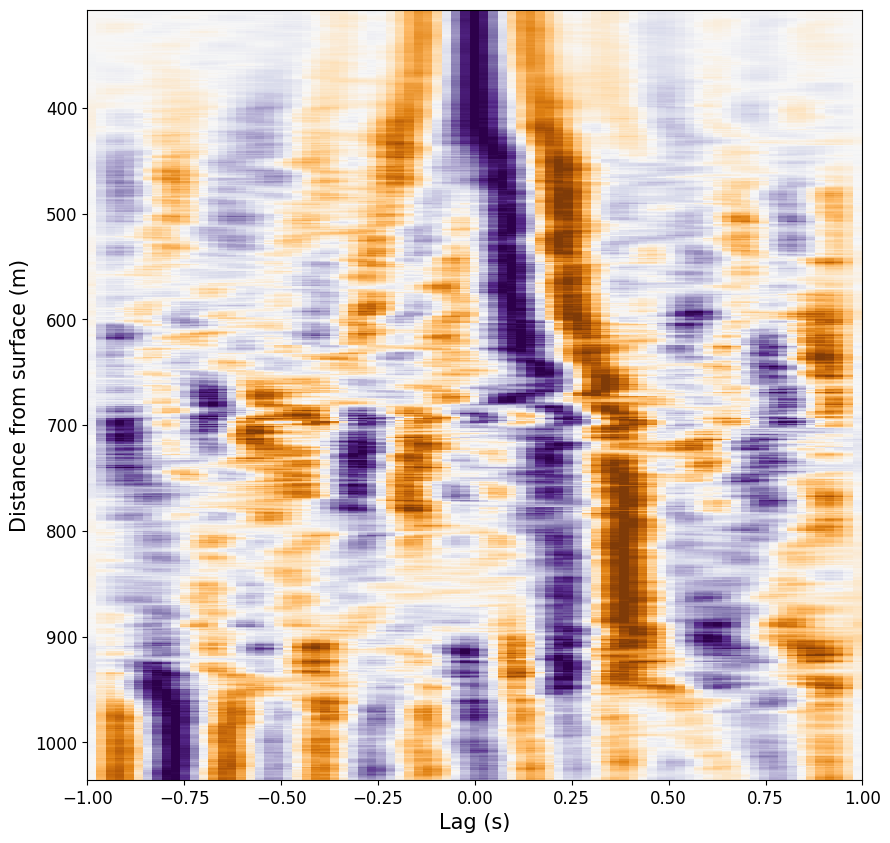

([300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0], PyCall.PyObject[PyObject Text(0, 300.0, '300'), PyObject Text(0, 400.0, '400'), PyObject Text(0, 500.0, '500'), PyObject Text(0, 600.0, '600'), PyObject Text(0, 700.0, '700'), PyObject Text(0, 800.0, '800'), PyObject Text(0, 900.0, '900'), PyObject Text(0, 1000.0, '1000'), PyObject Text(0, 1100.0, '1100')])

In [7]:
# make plot of single virtual source at the surface
plot_chans = collect(start_chan:midpoint)
indices = [j for j in combinations(plot_chans,2)]
indices = reduce(vcat,transpose.(indices))
shot_point = 631

ssp_ind = vec(indices[:,1] .== shot_point)

# get channel spacing
surface_channel = 330
S = read_nodal("segy", files[2])
spacing = (S.misc[4]["shot_point"]-S.misc[3]["shot_point"])/1000
profile_start = (indices[ssp_ind,1][1] - surface_channel) * spacing
profile_end = (indices[ssp_ind,2][end] - surface_channel) * spacing

# make a plot of the correlations
figure(figsize=(10,10))
extent=[-maxlag,maxlag,profile_end,profile_start]
imshow(C.corr[:,ssp_ind]', cmap="PuOr", interpolation=:none, aspect="auto",extent=extent)
ylabel("Distance from surface (m)",fontsize=15)
xlabel("Lag (s)",fontsize=15)
xticks(fontsize=12)
yticks(fontsize=12)

In [ ]:
# get channel spacing
plot_chans = collect(331:1344)
indices = [j for j in combinations(plot_chans,2)]
indices = reduce(vcat,transpose.(indices))
S = read_nodal("segy", files[2])
spacing = (S.misc[4]["shot_point"]-S.misc[3]["shot_point"])/1000

# get indices for naively-sorted-by-distance plot
distance_sort = sortperm(vec(diff(indices,dims=2)))
indices = indices[distance_sort,:]
distances = round.(diff(indices,dims=2).*spacing,digits=2)

# make a plot of the correlations
figure(figsize=(10,10))
extent=[-maxlag,maxlag,maximum(distances),minimum(distances)]
imshow(C.corr[:,distance_sort]', vmin=-1, vmax=1, cmap="PuOr", interpolation=:none, aspect="auto",extent=extent)
num_rows = size(indices)[1]
ylabel("Distance (m)")
xlabel("Lag (s)")

In [ ]:
# get indices for common midpoint gather plot
indices = [j for j in combinations(plot_chans,2)]
indices = reduce(vcat,transpose.(indices))
pos = plot_chans.*spacing
midpoint = pos[div(length(pos),2)+1]
distances = indices.*spacing
center_to_midpoint = mean(distances,dims=2) .- midpoint
cmp_ind = vec(abs.(center_to_midpoint) .<  10.0)
dist_to_mid = indices[cmp_ind,2] .- midpoint

# get channel spacing
S = read_nodal("segy", files[2])
spacing = (S.misc[4]["shot_point"]-S.misc[3]["shot_point"])/1000

# make a plot of the correlations
figure(figsize=(10,10))
extent=[-maxlag,maxlag,maximum(dist_to_mid),minimum(dist_to_mid)]
imshow(reverse(C.corr[:,cmp_ind]',dims=1), vmin=-1, vmax=1, cmap="PuOr", interpolation=:none, aspect="auto",extent=extent)
ylabel("Distance from common midpoint (m)")
xlabel("Lag (s)")

In [ ]:
# save substacks for only channel pairs within a certain distance, etc other filters
# can restrict which correlations actually get computed if desired (for instance, just a single virtual source)